In [1]:
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
import numpy as np
import cv2
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns

2023-11-15 17:21:47.207299: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 17:21:47.209288: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 17:21:47.254105: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 17:21:47.254151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 17:21:47.254184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
samples_dir = 'samples'
samples = os.listdir(samples_dir)

In [3]:
X = np.zeros((len(samples), 50, 200, 1))                                # Because the captcha image is 50x200 and grayscale
y = np.zeros((5, len(samples), 36))                                     # 5 characters per captcha, 36 possible characters (26 letters + 10 digits)

In [4]:
for i, sample in enumerate(samples):
    
    sample_path = os.path.join(samples_dir, sample)                     # Get sample path
    sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)          # Read sample as grayscale
    sample_img = sample_img / 255.0                                     # Normalize sample (0-1)
    sample_img = np.reshape(sample_img, (50, 200, 1))                   # Reshape sample to (50, 200, 1) for CNN
    X[i] = sample_img                                                   # Add sample to X                              

    symbols = string.ascii_lowercase + "0123456789"
    for j, symbol in enumerate(sample.split('.')[0]):
        y[j, i, symbols.find(symbol)] = 1.0                             # One-hot encode each character in the captcha

In [5]:
X_train, y_train = X[:int(len(X) * 0.9)], y[:, :int(len(X) * 0.9)]      # 90% of data for training
X_test, y_test = X[int(len(X) * 0.9):], y[:, int(len(X) * 0.9):]        # 10% of data for testing

In [6]:
captcha = layers.Input(shape=(50, 200, 1))                                        # Input layer            | 50x200x1
conv_1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(captcha)    # Convolutional layer 1  | 50x200x32
pool_1 = layers.MaxPooling2D((2, 2))(conv_1)                                      # Pooling layer 1        | 25x100x32
conv_2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(pool_1)     # Convolutional layer 2  | 25x100x64
pool_2 = layers.MaxPooling2D((2, 2))(conv_2)                                      # Pooling layer 2        | 12x50x64
conv_3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(pool_2)     # Convolutional layer 3  | 12x50x64
pool_3 = layers.MaxPooling2D((2, 2))(conv_3)                                      # Pooling layer 3        | 6x25x64

flat = layers.Flatten()(pool_3)                                                   # Flatten layer          | 9600
outs = []
for _ in range(5):                                                                # Creates 5 branches for the 5 characters and appends them to outs
    dense_1 = layers.Dense(256, activation='relu')(flat)                          # Dense layer 1          | 256
    drop_1  = layers.Dropout(0.5)(dense_1)                                        # Dropout layer 1        | 256
    dense_2 = layers.Dense(36, activation='softmax')(drop_1)                      # Dense layer 2          | 36
    outs.append(dense_2)

model = Model(captcha, outs)                                                      
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [8]:
result = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=2)

Epoch 1/100
28/28 - 10s - loss: 16.3989 - dense_1_loss: 3.2616 - dense_3_loss: 3.2814 - dense_5_loss: 3.2731 - dense_7_loss: 3.3096 - dense_9_loss: 3.2733 - dense_1_accuracy: 0.0543 - dense_3_accuracy: 0.0704 - dense_5_accuracy: 0.0727 - dense_7_accuracy: 0.0577 - dense_9_accuracy: 0.0739 - val_loss: 15.4822 - val_dense_1_loss: 3.0839 - val_dense_3_loss: 3.0982 - val_dense_5_loss: 3.0804 - val_dense_7_loss: 3.1200 - val_dense_9_loss: 3.0997 - val_dense_1_accuracy: 0.0619 - val_dense_3_accuracy: 0.1031 - val_dense_5_accuracy: 0.0619 - val_dense_7_accuracy: 0.1031 - val_dense_9_accuracy: 0.0722 - 10s/epoch - 370ms/step
Epoch 2/100
28/28 - 7s - loss: 15.3358 - dense_1_loss: 3.0397 - dense_3_loss: 3.0550 - dense_5_loss: 3.0686 - dense_7_loss: 3.0976 - dense_9_loss: 3.0750 - dense_1_accuracy: 0.0797 - dense_3_accuracy: 0.0889 - dense_5_accuracy: 0.0889 - dense_7_accuracy: 0.0774 - dense_9_accuracy: 0.0843 - val_loss: 14.5578 - val_dense_1_loss: 2.8322 - val_dense_3_loss: 2.8805 - val_dense_

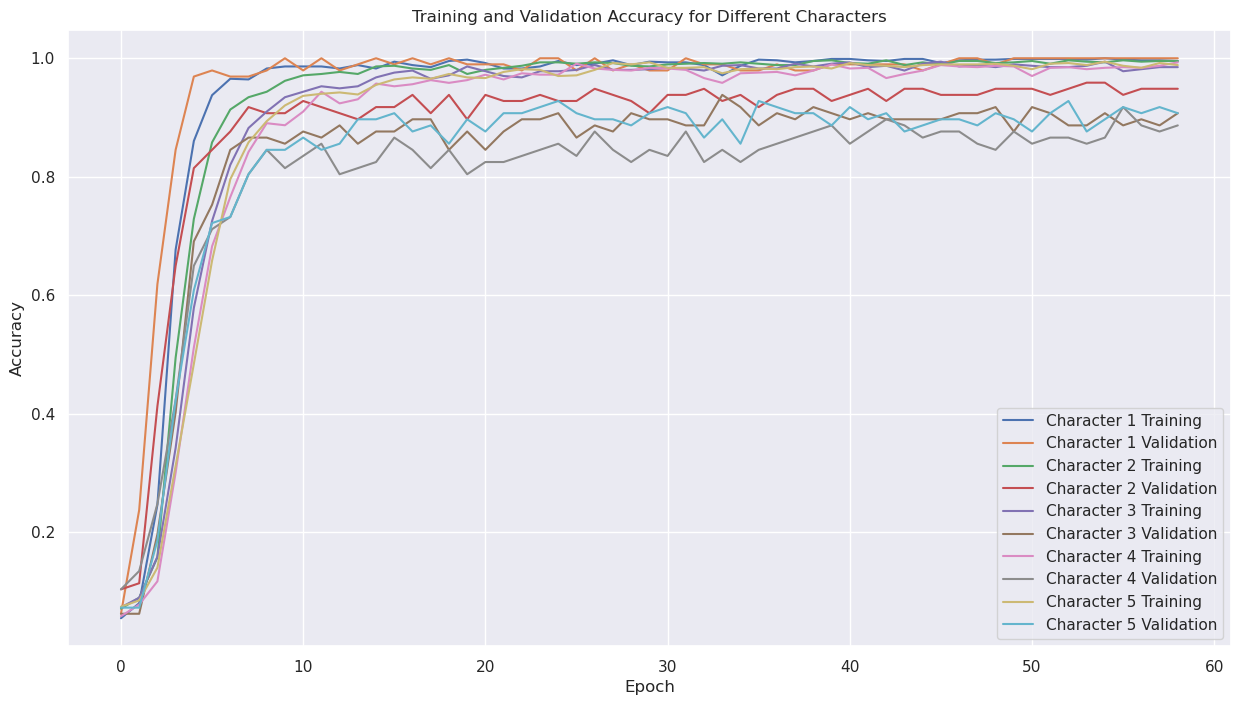

In [13]:
sns.set()
plt.figure(figsize=(15, 8))

for i in [1, 3, 5, 7, 9]:
    plt.plot(result.history[f'dense_{i}_accuracy'], label=f'Character {i//2+1} Training')
    plt.plot(result.history[f'val_dense_{i}_accuracy'], label=f'Character {i//2+1} Validation')

plt.title('Training and Validation Accuracy for Different Characters')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

4/4 [==============================] - 0s 44ms/step


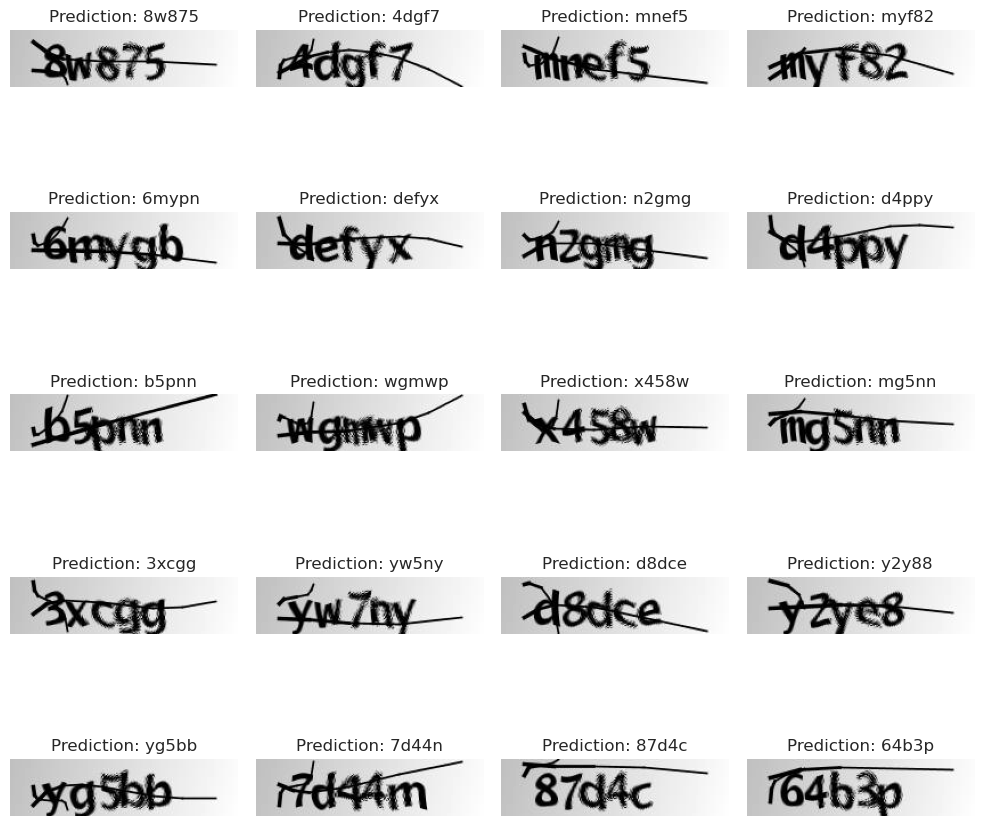

In [10]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=2)
captchas = []
symbols = string.ascii_lowercase + "0123456789"
for i in range(len(X_test)):
    captcha = ""
    for j in range(5):
        captcha += symbols[preds[j][i]]
    captchas.append(captcha)

plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[i].reshape(50, 200), cmap='gray')
    plt.title(f'Prediction: {captchas[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()